In [1]:
import os
import random
import math
import json
import yaml
import joblib
from ast import literal_eval

import torch
import pydantic
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import dgl

/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_embed_dict = joblib.load('../zillow_data/image_embed.joblib')
keyword_embed_dict = {}
scene_embed_dict = {}

keyword_embed_dictlist = joblib.load('../zillow_data/keyword_embed.joblib')
for dict in tqdm(keyword_embed_dictlist, desc='converting list to dict'):
    dict_key = list(dict.keys())[0]
    keyword_embed_dict[dict_key] = dict[dict_key]

scene_embed_dictlist = joblib.load('../zillow_data/scene_embed.joblib')
for dict in tqdm(scene_embed_dictlist, desc='converting list to dict'):
    dict_key = list(dict.keys())[0]
    scene_embed_dict[dict_key] = dict[dict_key]

modal_dicts = {
    'images': image_embed_dict,
    'keywords': keyword_embed_dict,
    'scenes': scene_embed_dict
}

converting list to dict: 100%|██████████| 18/18 [00:00<00:00, 385191.18it/s]


In [3]:
for modal in modal_dicts:
    print(f'Unique {modal} count: {len(list(modal_dicts[modal].keys()))}')

Unique images count: 82720
Unique keywords count: 1542
Unique scenes count: 18


In [4]:
node_links = pd.read_csv('../zillow_data/NYU_photoboard_file.csv')

# convert string object of image_keyword_hash column back to a list of keyword hashes
node_links['image_keyword_hash'] = node_links['image_keyword_hash'].apply(lambda x: literal_eval(x))
node_links = node_links.rename(columns={'url_hash': 'image_hash', 'image_keyword_hash': 'keyword_hash'})

print('Total rows:', len(node_links))

node_links_keywords_only = node_links[node_links['keyword_hash'].apply(lambda x: x!=[])]
print('Pct of images with at least one keyword:', len(node_links_keywords_only) / len(node_links))
node_links.head()


Total rows: 130065
Pct of images with at least one keyword: 0.2462076653980702


,scene_hash,keyword_hash,image_hash,propertyIdhash
0,67e69903823c5a541b29be07e784b7e6,[],8f1c8d0b5b7cc98231cdea9f923d928e,a3d2de7675556553a5f08e4c88d2c228
1,60825cdcaad5cba560a6f63c895e1f3b,"[851112d8c835d58c497101d9886a1348, b10a8c0bede...",f2d2571c7b9a1e124b188f84222be032,6b693c1082a8f8b747d0db60d179b7b2
2,624109635107c411520779cf9c82ad65,[],3feadc281c74873a6e55a4ab83ebd623,c871527ccd30371d69d21faa47008f12
3,624109635107c411520779cf9c82ad65,[],71906fef662e966b21afa3d53b92decd,c871527ccd30371d69d21faa47008f12
4,624109635107c411520779cf9c82ad65,[],163c91537b81f3ad637d9ceb771e2e1d,c871527ccd30371d69d21faa47008f12


In [8]:
def train_val_test_ids(node_ids):
    node_ids_copy = node_ids.copy()
    random.shuffle(node_ids_copy)
    n = len(node_ids_copy)
    train_ct, val_ct = [math.floor(n*0.7), math.ceil(n*0.15)]
    return [node_ids_copy[0:train_ct], node_ids_copy[train_ct:train_ct+val_ct], node_ids_copy[train_ct+val_ct:]]

def split_mask(node_id, split_ids):
    return True if node_id in split_ids else False

def nodes_table(modal, modal_dict):
    node_ids = list(modal_dict.keys())
    nodes = pd.DataFrame({'node_id': list(node_ids)})
    train_ids, val_ids, test_ids = train_val_test_ids(node_ids)

    tqdm.pandas(desc='applying train masks')
    nodes['train_mask'] = nodes['node_id'].progress_apply(lambda x: split_mask(x, train_ids))
    tqdm.pandas(desc='applying val masks')
    nodes['val_mask'] = nodes['node_id'].progress_apply(lambda x: split_mask(x, val_ids))
    tqdm.pandas(desc='applying test masks')
    nodes['test_mask'] = nodes['node_id'].progress_apply(lambda x: split_mask(x, test_ids))
    
    tqdm.pandas(desc=f'formatting {modal} node embeddings')
    nodes['feat'] = nodes['node_id'].progress_apply(lambda x: ', '.join([str(y) for y in modal_dict[x].tolist()]))

    return nodes

nodes_table_modals = pd.DataFrame()
for modal in modal_dicts:
    nodes_table_modals = pd.concat([nodes_table_modals, nodes_table(modal, modal_dicts[modal])])

nodes_table_modals = nodes_table_modals['node_id'].drop_duplicates()

formatting scenes node embeddings: 100%|██████████| 18/18 [00:00<00:00, 2935.25it/s]


In [7]:
'''
Notes about the node_links dataframe:
    - ~130,000 total roows
    - scene_hash is always populated
    - keywords_hash is a list of keyword hashes, usually an empty list (at least one entry for ~25% of images)
'''

def edges_table(node_links):
    edges = pd.DataFrame(columns=['src_id', 'dst_id'])
    for i in tqdm(range(len(node_links)), desc='parsing data into edges'):
        row = node_links.iloc[i,:]
        edges_subset = {'src_id': [], 'dst_id': []}
        edges_subset['src_id'].append(row['image_hash'])
        edges_subset['dst_id'].append(row['scene_hash'])
        for keyword in row['keyword_hash']:
            edges_subset['src_id'].append(row['image_hash'])
            edges_subset['dst_id'].append(keyword)
        edges = pd.concat([edges, pd.DataFrame(edges_subset)])

    return edges

edges = edges_table(node_links)
edges.head()

parsing data into edges: 100%|██████████| 130065/130065 [03:36<00:00, 601.48it/s]


,src_id,dst_id
0,8f1c8d0b5b7cc98231cdea9f923d928e,67e69903823c5a541b29be07e784b7e6
0,f2d2571c7b9a1e124b188f84222be032,60825cdcaad5cba560a6f63c895e1f3b
1,f2d2571c7b9a1e124b188f84222be032,851112d8c835d58c497101d9886a1348
2,f2d2571c7b9a1e124b188f84222be032,b10a8c0bede9eb4ea771b04db3149f28
3,f2d2571c7b9a1e124b188f84222be032,6160972776d990112e5df1ceb938816c


In [9]:
# Store graph csv files

if not os.path.exists('zillow_graph_csv'):
    os.mkdir('zillow_graph_csv')

edges.to_csv('zillow_graph_csv/zillow_edges.csv', index=False)
nodes_table_modals.to_csv('zillow_graph_csv/zillow_nodes.csv', index=False)

g_metadata = {
    'dataset_name': 'zillow_graph',
    'edge_data': [{'file_name': 'zillow_edges.csv'}],
    'node_data': [{'file_name': 'zillow_nodes.csv'}]
}

with open('zillow_graph_csv/meta.yaml', 'w') as file:
    yaml.dump(g_metadata, file)

In [10]:
zillow_graph_dataset = dgl.data.CSVDataset('./zillow_graph_csv')
zillow_graph_dataset

Done saving data into cached files.


Dataset("zillow_graph", num_graphs=1, save_path=./zillow_graph_csv/zillow_graph)

In [11]:
zillow_graph_dataset[0]

Graph(num_nodes=84270, num_edges=226807,
      ndata_schemes={}
      edata_schemes={})

KeyboardInterrupt: 

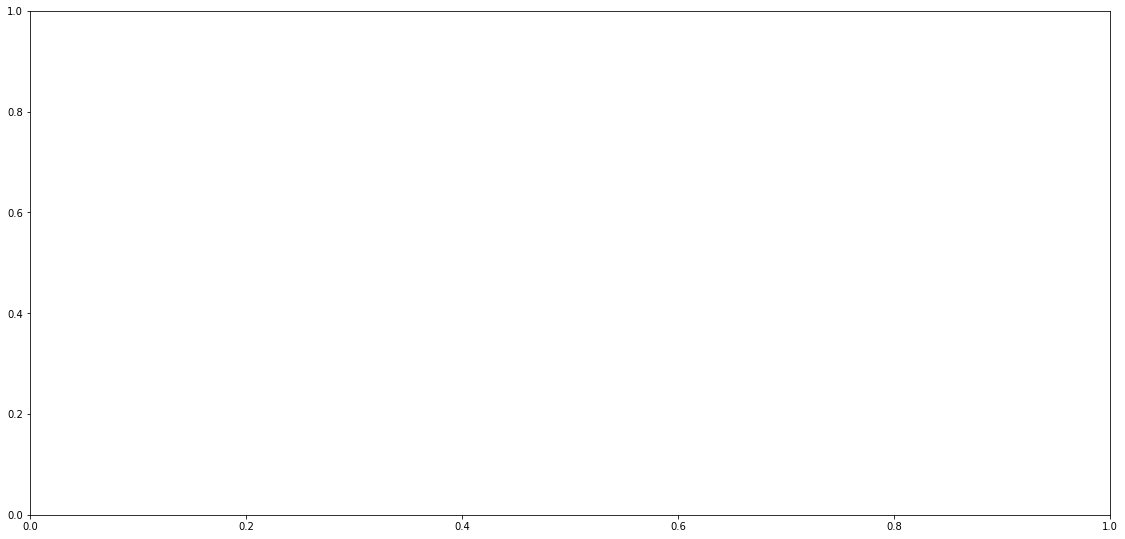

In [12]:
g = zillow_graph_dataset[0]
options = {
    'node_color': 'blue',
    'node_size': 10,
    'width': 1,
}
G = dgl.to_networkx(g)
plt.figure(figsize=[15,7])
nx.draw(G, **options)